### Emotions.

In this notebook we are going to create a pytorch model using torchtext and our custom dataset that identifies emotions of a given sentence without torchtext.

### Emotions:
````
😞 -> sadness
😨 -> fear
😄 -> joy
😮 -> surprise
😍 -> love
😠 -> anger
````

We are going to use our custom dataset that we will load from my google drive. The dataset that we are going to use was found on [kaggle](https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp).

### Structure of the data.

We have three files which are:
* test.txt
* train.txt
* val.txt
And each of these file contains lines with a respective label. The text in these files looks as follows:

```txt
im feeling quite sad and sorry for myself but ill snap out of it soon;sadness
i feel like i am still looking at a blank canvas blank pieces of paper;sadness
i feel like a faithful servant;love
```

### Installing Helper Packages
In the following code cell we are going to install the package called ``helperfns`` that provide us with some usefull helper functions for machine learning.

In [ ]:
!pip install helperfns kaggle pigmenta -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.5/186.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.3/650.3 kB 29.5 MB/s eta 0:00:00


### Imports

In the following code cell we are going to import all the packages that we are going to use throughout this notebook

In [ ]:
import json
import time
import torch
import os
import random
import spacy
import en_core_web_sm
from collections import Counter, defaultdict
from helperfns.tables import tabulate_data
from helperfns.visualization import plot_complicated_confusion_matrix
from helperfns.utils import hms_string
from torch import nn
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from spacy.lang.en import English

import pandas as pd
import numpy as np
import torch.nn.functional as F
import wordcloud as wc

torch.__version__

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


'2.6.0+cu124'

### Setting seeds


In the following code cell we are going to set the seed to all random operations for reproducivity.

In [ ]:
SEED = 23
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deteministic = True

### Device
In the following code cell we are going to get ``gpu`` device if possible

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data
We are going to download the data from `kaggle` at this url: https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp

In [ ]:
with open('kaggle.json', 'r') as reader:
  keys = json.loads(reader.read())
  os.environ['KAGGLE_USERNAME'] = keys['username']
  os.environ['KAGGLE_KEY'] = keys['key']

In [ ]:
!kaggle datasets download praveengovi/emotions-dataset-for-nlp --unzip

Dataset URL: https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp
License(s): CC-BY-SA-4.0
  0% 0.00/721k [00:00<?, ?B/s]
100% 721k/721k [00:00<00:00, 1.14GB/s]


### Word Embeddings

In the following code cell we are going to download word embeddings from kaggle:

url: https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation

In [ ]:
!kaggle datasets download rtatman/glove-global-vectors-for-word-representation --unzip # glove vectors

Dataset URL: https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation
License(s): other
 95% 434M/458M [00:03<00:00, 108MB/s] 
100% 458M/458M [00:03<00:00, 124MB/s]


Next we are going to read our data from text files into pandas dataframe using the `read_csv` method.

In [ ]:
train_df = pd.read_csv('train.txt', delimiter=';', names=['text', 'emotion'])
test_df = pd.read_csv('test.txt', delimiter=';', names=['text', 'emotion'])
valid_df = pd.read_csv('val.txt', delimiter=';', names=['text', 'emotion'])
train_df.head(2)

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness


### Data Analyisis

In this section of the notebook we are going to check how the data is distributed within our 3 sets.

First we are going to have a look at how the emotions were distributed in the `train` set.

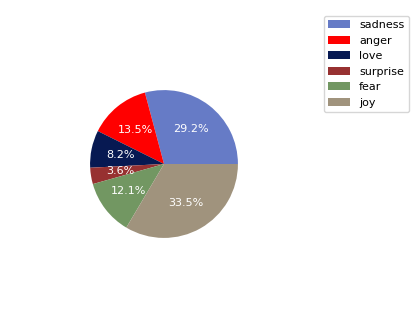

In [ ]:

train_dist_emotions	= {i:0 for i in train_df.emotion.unique()}
for rating in train_df.emotion:
  train_dist_emotions[rating] += 1

plt.figure(figsize=(4, 4))
plt.pie(train_dist_emotions.values(), labels=train_dist_emotions.keys(), autopct='%1.1f%%', textprops={'color': 'white', 'fontsize':8}, radius=.6,
        colors=['#667BC6', '#FF0000', '#071952', '#973131', '#729762', '#A0937D'])
plt.legend(fontsize=8, labels=list(train_dist_emotions.keys()), bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

We can see that most of the emotions that are in the dataset are for `joy`. Next we are going to check for the most common words in the `train` set using a word cloud plot.

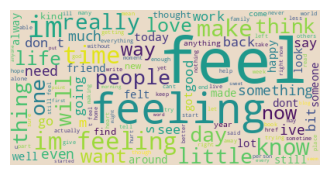

In [ ]:
emotional_text = ' '.join(train_df.text.values)
image = wc.WordCloud(background_color="#EADBC8", max_words=10_000,
                contour_width=3, contour_color='firebrick').generate(emotional_text)
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.axis("off")
plt.show()

We can see that the most common words in the emotion text of the train data set are `feel`, `feeling`, `love`, `people` which basically shows that indeed this dataset is about human emotions.


In the next code cell we are going to visulize and show how the `emotions` were distributed in the test dataset.

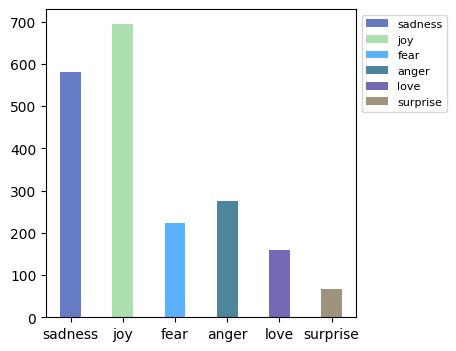

In [ ]:
test_dist_emotions	= {i:0 for i in test_df.emotion.unique()}
for rating in test_df.emotion:
  test_dist_emotions[rating] += 1

plt.figure(figsize=(4, 4))
plt.bar(list(test_dist_emotions.keys()), list(test_dist_emotions.values()), width=.4,label=test_dist_emotions.keys(),
        color=['#667BC6', '#ACE1AF', '#5AB2FF', '#4D869C', '#7469B6', '#A0937D'])
plt.legend(fontsize=8, labels=list(test_dist_emotions.keys()), bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

Again we can see that most of the emotions in the dataset are about `joy` and `sadness` which are the most common emotions that are found in human beings. Next we are going to show using word-clouds plot to show the most common words in the test datast.

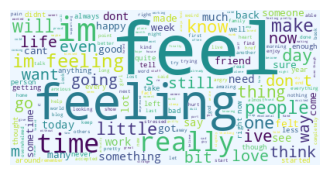

In [ ]:
emotional_text = ' '.join(test_df.text.values)
image = wc.WordCloud(background_color="#EEF7FF", max_words=10_000,
                contour_width=3, contour_color='firebrick').generate(emotional_text)
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.axis("off")
plt.show()

We can still see that most of the emotions in the dataset are about `joy` and `sadness` which are the most common emotions that are found in human beings.

In the next code cell we are going to visulize and show how the `emotions` were distributed in the `validation` dataset

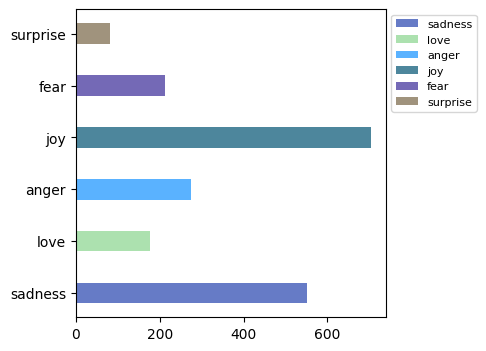

In [ ]:
val_dist_emotions	= {i:0 for i in valid_df.emotion.unique()}
for rating in valid_df.emotion:
  val_dist_emotions[rating] += 1

plt.figure(figsize=(4, 4))
plt.barh(list(val_dist_emotions.keys()), list(val_dist_emotions.values()), height=.4,label=val_dist_emotions.keys(),
        color=['#667BC6', '#ACE1AF', '#5AB2FF', '#4D869C', '#7469B6', '#A0937D'])
plt.legend(fontsize=8, labels=list(val_dist_emotions.keys()), bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

We can still see that most of the emotions in the dataset are about `joy` and `sadness` which are the most common emotions that are found in human beings.


In the following code cell we are going to display the most common words that appears in the `validation` test text using a word cloud plot.

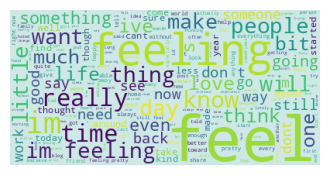

In [ ]:
emotional_text = ' '.join(valid_df.text.values)
image = wc.WordCloud(background_color="#CDE8E5", max_words=10_000,
                contour_width=3, contour_color='firebrick').generate(emotional_text)
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.axis("off")
plt.show()

We can see that indeed the dataset is still talking about human emotions based on the most common words that are appearing which are  `feel`, `feeling`, `love`, `people`.


Next let's visualize how many examples are there in each `set`.

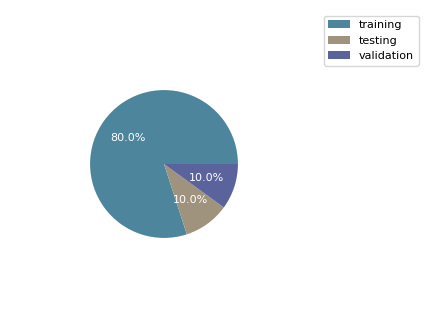

In [ ]:
plt.figure(figsize=(4, 4))
plt.pie([len(train_df), len(test_df), len(valid_df)], labels=['training', 'testing', 'validation'],
        autopct='%1.1f%%', textprops={'color': 'white', 'fontsize':8}, radius=.6,
        colors=['#4D869C', '#A0937D', '#5A639C'])
plt.legend(fontsize=8, labels=['training', 'testing', 'validation'], bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

``80%`` of the data is in the training set, ``10%`` in the test set and ``10%`` in the validation set.


### Features and Labels
Our fetures are the actual ``text`` in the dataframes which is the column named ``text`` and our labels will come from the column called `emotion`. In the following code cell we are going to read features and labels in a numpy arrays for each set.

In [ ]:
# train
train_texts = train_df.text.values
train_labels = train_df.emotion.values

# test
test_texts = test_df.text.values
test_labels = test_df.emotion.values

# val
val_texts = valid_df.text.values
val_labels = valid_df.emotion.values

### Text Preprocessing
In our text processing pipeline we need to do the following steps:

1. ``tokenize sentences``
* this is the process of converting a sentence or text into senquence of word. For this process we are going to use a pre-trained model from ``spacy`` language model.

2. ``vocabulary``
* We will to create a vocabulary based on our sentences that are in the train dataset. A ``vocabulary`` is esentially a word to index mapping that allows us to reference the word with their integer representation, since machine leaning models does not understand words. This vocabulary will be used during model training and also can be used at model inference.

### Tokenizer
In the following code cell we are going to get a tokenier object that will convert a sentence into a sequence of word using the ``spacy-en`` language model. The reason we are using the english langauge model it's because our ``text`` are in ``english``.

In [ ]:
def tokenizer(sent:str)->list[str]:
   return [t for t in English().tokenizer(sent)]
tokenizer("This is a boy."), len(tokenizer("This is a boy."))

([This, is, a, boy, .], 5)

### Vocabulary
In the following code cell we are going to create a vocabulary object.  So we are going to use the ``Counter`` module from collections to generate these counts from our ``train`` text.


In [ ]:
words = []
for line in train_texts:
    words.extend(line.split(" "))

counter = Counter(words)
counter.most_common(10)

[('i', 25859),
 ('feel', 11183),
 ('and', 9589),
 ('to', 8972),
 ('the', 8370),
 ('a', 6200),
 ('feeling', 5112),
 ('that', 5112),
 ('of', 4990),
 ('my', 4283)]

We are going to specify the ``min_freq`` to ``2`` meaning that the words that does not appear at least ``2`` times will be converted to unknown. We are also going to specify the special tokens during creation of the vocabulary object.

In [ ]:
class vocab:
    def __init__(self, counter, min_freq=1, specials=('[unk]', '[pad]', '[sos]', '[eos]')):
        self.freqs = counter
        self.itos = list(specials)
        self.stoi = {}
        for token, freq in counter.items():
            if freq >= min_freq and token not in self.itos:
                self.itos.append(token)

        self.stoi = defaultdict(lambda: self.itos.index('[unk]'))  # default to unk
        for idx, token in enumerate(self.itos):
            self.stoi[token] = idx

    def __len__(self):
        return len(self.itos)

    def __getitem__(self, token):
        return self.stoi[token]

    def get_stoi(self):
        return self.stoi
    def get_itos(self):
        return self.itos


vocabulary = vocab(counter, min_freq=2, specials=('[unk]', '[pad]', '[sos]', '[eos]'))

### STOI - ``String To Integer``
This will be a dictionary that contains a string to integer mapping which will be our actual vocabulary. In the following code cell we are going to create object called stoi which is essentially a dictionary of word to index mapping. This dictionary will be used during training as well as during model inference.

In [ ]:
stoi = vocabulary.get_stoi()

### Text Pipeline
After our text has been tokenized we need a way of converting those words into numbers because machine leaning models understand numbers not words. That's where we the ``text_pipeline`` function comes into play. So this function takes in a sentence and tokenize it then converts each word to a number. Note that the word that does not exists in the vocabulay (``stoi``) will be converted to an unkown (``'[unk]'``) token (0).

In [ ]:
def text_pipeline(x: str):
  values = list()
  tokens = x.lower().split(" ") # convert to lower case.
  for token in tokens:
    try:
      v = stoi[token]
    except KeyError as e:
      v = stoi['[unk]']
    values.append(v)
  return values

### Label pipeline
Our labels for now are just textual. We also need to convert these labels into numbers. This is very simple what we need to do is to get all the uniqe labels and then create a ``labels_vocab`` which is a label to integer representation.

In [ ]:
labels_dict = {k: v for v, k in enumerate(train_df.emotion.unique())}
labels_dict

{'sadness': 0, 'anger': 1, 'love': 2, 'surprise': 3, 'fear': 4, 'joy': 5}

The ``label_pipeline`` function will then takes in the label and then returns us an integer representation of that label.

In [ ]:
label_pipeline = lambda x: labels_dict[x]

### Pretrained vectors
In the following code cell we are going to download the predtrained word vectors. We are going to use the ``GloVe.6B.100d``. These are pretrained vectors that were trained with about ``~6B`` words and have a vector representation of a word in ``100`` dimension for each word.

In [ ]:
embedding_path = "glove.6B.100d.txt"
EMBEDDING_DIM = 100
glove_vectors = dict()
with open(embedding_path, encoding="utf8") as glove:
  for line in glove:
    records = line.split();
    word = records[0]
    vectors = np.asarray(records[1: ], dtype=np.float32)
    glove_vectors[word] = vectors

### Creating Embedding matrix
Now that we have our glove vectors we need to costomize them so that they fit our use case. We are going to create an embedding matrix that suits the our vocabulary. So essentially this embedding matrix will be the word to vector mapping for all the words that arein our vocabulary.

In [ ]:
VOCAB_SIZE = len(stoi)
EMBEDDING_MATRIX= torch.zeros([VOCAB_SIZE, EMBEDDING_DIM])
for word, index in stoi.items():
  vector = glove_vectors.get(word)
  if vector is not None:
    try:
      EMBEDDING_MATRIX[index] = torch.from_numpy(vector)
    except IndexError or Exception:
      pass


In the followig code cell we are going to check the embedding matrix for the word ``"people"``.

In [ ]:
EMBEDDING_MATRIX[stoi['people']]

tensor([ 0.2902,  0.8050,  0.3119, -0.3271, -0.4724,  1.1363, -0.3797,  0.1157,
         0.4191,  0.0163, -0.0654, -0.0040,  0.7769, -0.2494,  0.1882, -0.6401,
        -0.0203, -0.1853, -1.0651,  0.6912,  1.0472,  0.3617,  0.8086, -0.4277,
        -0.1830, -0.2785,  0.4384, -0.0233,  0.3736, -0.3588,  0.4726,  0.7395,
         0.0151,  0.0599, -0.0668, -0.3884,  0.2236,  0.8057,  0.3379, -0.0522,
        -1.1057, -0.1113,  0.1510, -0.6665, -0.0450, -0.0682,  0.0990, -0.5594,
        -0.7811, -0.5095, -0.3733, -0.7567,  0.2258,  1.2963, -0.4818, -1.8180,
         0.3853, -0.2185,  2.2418,  0.2009, -0.3521,  1.4893, -0.2170, -0.2462,
         0.5519,  0.9722,  0.5853, -0.0298,  0.5794, -0.6480, -0.1237, -0.5346,
        -0.2053, -0.5360,  0.3090,  0.5393,  0.1185,  0.4275, -1.0872, -0.2341,
         0.7388,  0.1575, -0.5664,  0.1623, -1.9117, -0.0193, -0.5029, -0.1758,
        -0.5388, -0.3940,  0.8133, -0.3165,  0.2597, -0.4820, -1.4452,  0.2742,
        -0.7265, -0.3360,  0.4600, -0.11

### Creating Dataset for Training
In the following code cell we are going to create a dataset class called `EmotionDataset`. This dataset will takes in the labels and the text of a set.

In [ ]:
class EmotionDataset(torch.utils.data.Dataset):
  def __init__(self, labels, text):
    super(EmotionDataset, self).__init__()
    self.labels = labels
    self.text = text

  def __getitem__(self, index):
    return self.labels[index], self.text[index]

  def __len__(self):
    return len(self.labels)

### ``collate_fn``
We are going to create a collate function called ``tokenize_batch``. This function actually takes in a batch and does the preprocessing of the ``text`` and ``labels``. This function will be passed to the ``DataLoader`` class to do the preprocessing of ``features`` and ``labels``.

### ``tokenize_batch`` function:

* this function takes in a batch in each set and convert the features and labels to integer representation.
* It goes ahead and ``pad`` and ``truncate`` the sequence to the same length and returns ``labels`` and ``features``.

In [ ]:
def tokenize_batch(batch, max_len=100, padding="pre"):
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  labels_list, text_list = [], []
  for _label, _text in batch:
    labels_list.append(label_pipeline(_label))
    text_holder = torch.zeros(max_len, dtype=torch.int32)
    processed_text = torch.tensor(text_pipeline(_text.lower()), dtype=torch.int32)
    pos = min(max_len, len(processed_text))
    if padding == "pre":
      text_holder[:pos] = processed_text[:pos]
    else:
      text_holder[-pos:] = processed_text[-pos:]
    text_list.append(text_holder.unsqueeze(dim=0))
  #  the labels will be torch long tensors since it is a multi-class classification.
  return torch.LongTensor(labels_list), torch.cat(text_list, dim=0)

### Datasets
In the following code cell we are going to create the datasets for all our three sets using the `EmotionDataset` class.

In [ ]:
train_dataset = EmotionDataset(train_labels, train_texts)
test_dataset = EmotionDataset(test_labels, test_texts)
val_dataset = EmotionDataset(val_labels, val_texts)

### Iterators
In the following code cell we are going to create loaders using the ``DataLoader`` class from ``torch.utils.data`` for our ``3`` sets. We are going to use the ``batch_size`` of ``100`` and our ``collate_function`` is ``tokenize_batch``. For the validation and testing dataset we are going to set the ``shuffle`` to ``False`` because there's no need fo us to shuffle these examples.

In [ ]:
BATCH_SIZE = 100
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=tokenize_batch)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)

Checking a single Batch Data

In [ ]:
lbl, txt = next(iter(train_loader))

Labels in the first batch.

In [ ]:
lbl

tensor([5, 0, 0, 5, 0, 0, 5, 0, 0, 5, 5, 0, 1, 0, 0, 2, 5, 1, 5, 1, 3, 2, 4, 5,
        1, 5, 5, 5, 1, 5, 3, 0, 2, 5, 0, 4, 0, 5, 3, 0, 4, 3, 5, 5, 2, 3, 2, 5,
        5, 3, 4, 5, 5, 1, 0, 0, 3, 2, 5, 1, 5, 5, 0, 5, 5, 0, 0, 0, 5, 2, 2, 2,
        0, 1, 4, 4, 2, 4, 5, 0, 1, 4, 0, 0, 1, 5, 0, 0, 0, 0, 5, 1, 5, 4, 4, 5,
        5, 0, 5, 4])

The first sentence in the batch.

In [ ]:
txt[0]

tensor([   4,    6,  654, 6338,   14,   28, 3835,   24,  512,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0], dtype=torch.int32)

### Models.

We are going to create `3` models which will be named:

1. `EmotionsBiLSTM` - This model will be buit using `LSTM` layers.
2. `EmotionsBiGRU` - This model will be buit using `GRU` layers.
3. `EmotionsCNN` - This model will be buit using `CNN` layers.


### 1. `EmotionsBiLSTM`

In the following code cell we are going to build a model using `LSTM` layers.

In [ ]:
class EmotionsBiLSTM(nn.Module):
  def __init__(self, vocab_size, embedding_size,
               hidden_size, output_size, num_layers,
               bidirectional, dropout, pad_index
               ):
    super(EmotionsBiLSTM, self).__init__()
    self.embedding = nn.Sequential(
          nn.Embedding(
              vocab_size, embedding_size, padding_idx=pad_index
        )
    )

    self.lstm = nn.Sequential(
          nn.LSTM(
              embedding_size, hidden_size = hidden_size,
              bidirectional=bidirectional,
              num_layers=num_layers,
              dropout = dropout,
              batch_first=True,
          )
    )
    self.out = nn.Sequential(
        nn.Linear(hidden_size * 2, out_features=output_size)
    )

  def forward(self, text, text_lengths):
    embedded = self.embedding(text)
    packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths, batch_first=True, enforce_sorted=False
    )
    packed_output, (hidden, cell) = self.lstm(packed_embedded)
    if self.lstm[0].bidirectional:
      hidden = torch.cat([hidden[-1], hidden[-2]], dim=-1)
    else:
      hidden = hidden[-1]
    return self.out(hidden)

In the following code cell we are going to create a model instance of the `BiLSTM` model.

In [ ]:
INPUT_DIM = VOCAB_SIZE
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = len(labels_dict)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = stoi['[pad]']
bilstm_model = EmotionsBiLSTM(
              INPUT_DIM,
              EMBEDDING_DIM,
              HIDDEN_DIM,
              OUTPUT_DIM,
              N_LAYERS,
              BIDIRECTIONAL,
              DROPOUT,
              PAD_IDX
).to(device)
bilstm_model


EmotionsBiLSTM(
  (embedding): Sequential(
    (0): Embedding(7459, 100, padding_idx=1)
  )
  (lstm): Sequential(
    (0): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  )
  (out): Sequential(
    (0): Linear(in_features=512, out_features=6, bias=True)
  )
)

### 2. `EmotionsBiGRU`

In the following code cell we are going to build a model using `GRU` layers.

In [ ]:
class EmotionsBiGRU(nn.Module):
  def __init__(self, vocab_size, embedding_size,
               hidden_size, output_size, num_layers,
               bidirectional, dropout, pad_index
               ):
    super(EmotionsBiGRU, self).__init__()
    self.embedding = nn.Sequential(
          nn.Embedding(
              vocab_size, embedding_size, padding_idx=pad_index
        )
    )

    self.gru = nn.Sequential(
          nn.GRU(
              embedding_size, hidden_size = hidden_size,
              bidirectional=bidirectional,
              num_layers=num_layers,
              dropout = dropout,
              batch_first=True,
          )
    )
    self.out = nn.Sequential(
        nn.Linear(hidden_size * 2, out_features=output_size)
    )

  def forward(self, text, text_lengths):
    embedded = self.embedding(text)
    packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths, batch_first=True, enforce_sorted=False
    )
    packed_output, hidden = self.gru(packed_embedded)
    if self.gru[0].bidirectional:
      hidden = torch.cat([hidden[-1], hidden[-2]], dim=-1)
    else:
      hidden = hidden[-1]
    return self.out(hidden)

Next we are going to create an instance of a `EmotionsBiGRU`.

In [ ]:
bigru_model = EmotionsBiGRU(
              INPUT_DIM,
              EMBEDDING_DIM,
              HIDDEN_DIM,
              OUTPUT_DIM,
              N_LAYERS,
              BIDIRECTIONAL,
              DROPOUT,
              PAD_IDX
).to(device)
bigru_model

EmotionsBiGRU(
  (embedding): Sequential(
    (0): Embedding(7459, 100, padding_idx=1)
  )
  (gru): Sequential(
    (0): GRU(100, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  )
  (out): Sequential(
    (0): Linear(in_features=512, out_features=6, bias=True)
  )
)

### 3. `EmotionsCNN`

In the following code cell we are going to build a model using `CNN` layers. We are going to use the `Convulution1d` layers.

In [ ]:
class EmotionsCNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim,
            dropout, pad_idx):
    super(EmotionsCNN, self).__init__()
    self.embedding = nn.Sequential(
        nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
    )
    self.convs = nn.Sequential(
        nn.ModuleList([
            nn.Conv1d(
                in_channels = embedding_dim,
                out_channels = n_filters,
                kernel_size = fs
              ) for fs in filter_sizes
        ])
    )
    self.out = nn.Sequential(
        nn.Linear(len(filter_sizes) * n_filters, output_dim)
    )
    self.dropout = nn.Dropout(dropout)

  def forward(self, text, lenght=None):
    embedded = self.embedding(text)
    embedded = embedded.permute(0, 2, 1)
    conved = [F.relu(conv(embedded)) for conv in self.convs[0]]
    pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
    cat = self.dropout(torch.cat(pooled, dim = 1))
    return self.out(cat)

In the following code cell we are going to create an instance of a `CNN` model.

In [ ]:
INPUT_DIM = VOCAB_SIZE
EMBEDDING_DIM = 100
DROPOUT = 0.5
N_FILTERS = 100
FILTER_SIZES = [3, 4, 5]

cnn_model = EmotionsCNN(
 INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX
).to(device)
cnn_model

EmotionsCNN(
  (embedding): Sequential(
    (0): Embedding(7459, 100, padding_idx=1)
  )
  (convs): Sequential(
    (0): ModuleList(
      (0): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
      (1): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
      (2): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
    )
  )
  (out): Sequential(
    (0): Linear(in_features=300, out_features=6, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

### Model Parameters

In the following code cell we are going to count parameters of each model achitecture and visualize it using a table.

In [ ]:
def count_trainable_params(model):
  return f"{sum(p.numel() for p in model.parameters()):,}", f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,}"

columns = ["MODEL", "TOTAL PARAMS", "TRAINABLE PARAMS"]
data = [
    ["BiLSTM", *count_trainable_params(bilstm_model)],
    ["BiGRU", *count_trainable_params(bigru_model)],
    ["CNN", *count_trainable_params(cnn_model)]
]
tabulate_data(columns, data, title="Models Parameters")

Models Parameters
+--------+--------------+------------------+
| MODEL  | TOTAL PARAMS | TRAINABLE PARAMS |
+--------+--------------+------------------+
| BiLSTM |    3,059,122 |        3,059,122 |
| BiGRU  |    2,481,586 |        2,481,586 |
| CNN    |      868,006 |          868,006 |
+--------+--------------+------------------+


### Loading Embedding Vectors
In the following code cells we are going to load the pretained custom vectors in our embedding layer to our models. We are going to load the embedding vectors tha suits our data using the ``model.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)``

In [ ]:
EMBEDDING_MATRIX.size(0)

7459

In [ ]:
bilstm_model.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)

tensor([[ 0.5551,  0.4613, -0.2429,  ...,  0.3746, -0.2499,  0.3411],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')

In [ ]:
bigru_model.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)

tensor([[ 0.5551,  0.4613, -0.2429,  ...,  0.3746, -0.2499,  0.3411],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')

In [ ]:
cnn_model.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)

tensor([[ 0.5551,  0.4613, -0.2429,  ...,  0.3746, -0.2499,  0.3411],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')

### Optimizer and Criterion
In the following code cell we are going to define the ``optimizers``
 for all the 3 models and a single criterion. For the ``optimizer`` we are going to use the ``Adam`` optimizer with default parameters and for the criterion we are going to use the ``CrossEntropyLoss()`` function since this is a multi-class classification.

In [ ]:
bilstm_optimizer = torch.optim.Adam(bilstm_model.parameters())
bigru_optimizer = torch.optim.Adam(bigru_model.parameters())
cnn_optimizer = torch.optim.Adam(cnn_model.parameters())

criterion = nn.CrossEntropyLoss().to(device)

In the following code cell we are going to create our ``categorical_accuracy`` function, which is a function that calulates the the catecorical accuracy between the predicted labels and real labels.

In [ ]:
def categorical_accuracy(preds, y):
  top_pred = preds.argmax(1, keepdim = True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float() / y.shape[0]
  return acc

### Training and evaluation functions.

In the following code cell we are going to create our ``train`` and ``evalute`` functions:

In [ ]:
def train(model, iterator, optimizer, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.train()
  for batch in iterator:
    y, X = batch
    X = X.to(device)
    y = y.to(device)
    lengths = torch.tensor([len(i) for i in X])
    optimizer.zero_grad()

    predictions = model(X, lengths).squeeze(1)
    loss = criterion(predictions, y)
    acc = categorical_accuracy(predictions, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for batch in iterator:
      y, X = batch
      X = X.to(device)
      y = y.to(device)
      lengths = torch.tensor([len(i) for i in X])
      predictions = model(X, lengths).squeeze(1)
      loss = criterion(predictions, y)
      acc = categorical_accuracy(predictions, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

### Training Loop.

When training the model we are going to train each model surperately. And we are also going to keep on tracking the training history of each model. The following `History` class is a data structure for our training history.

In [ ]:
class History:
  def __init__(self):
    self.train_losses = list()
    self.train_acc = list()
    self.epoch_train_time = list()
    self.val_losses = list()
    self.val_acc = list()

  def add(self, train_loss:float, train_acc:float, val_loss:float, val_acc:float, elt:float):
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.train_acc.append(train_acc)
    self.val_acc.append(val_acc)
    self.epoch_train_time.append(elt)

### 1. Training the `LSTM` model

The folloing code cell will run a training loop for the `ltsm` model for `20` epochs.

In [ ]:
def run_train_loop(model, model_name, epochs=20, optimizer=None, criterion=None):
  best_valid_loss = float('inf')
  last_saved_epoch = 1
  history = History()
  training_start = time.time()
  for epoch in range(epochs):
    start = time.time()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion)
    title = f"EPOCH: {epoch+1:02}/{epochs:02} {'saving best model...' if valid_loss < best_valid_loss else 'not saving...'}"
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_name)
        last_saved_epoch = epoch+1
    end = time.time()
    history.add(train_loss, train_acc, valid_loss, valid_acc, end-start)
    data = [
        ["Training", f'{train_loss:.3f}', f'{train_acc:.3f}', f"{hms_string(end - start)}" ],
        ["Validation", f'{valid_loss:.3f}', f'{valid_acc:.3f}', "" ],
    ]
    columns = ["CATEGORY", "LOSS", "ACCURACY", "ETA"]
    tabulate_data(columns, data, title)

  training_end = time.time()
  return history, training_end - training_start, last_saved_epoch

In [ ]:
lstm_history, lstm_elt, last_saved_epoch = run_train_loop(
    bilstm_model, 'lstm.pt', 20, optimizer=bilstm_optimizer, criterion=criterion
)

EPOCH: 01/20 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 1.341 |    0.486 | 0:00:10.39 |
| Validation | 0.906 |    0.679 |            |
+------------+-------+----------+------------+
EPOCH: 02/20 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.682 |    0.766 | 0:00:09.61 |
| Validation | 0.434 |    0.856 |            |
+------------+-------+----------+------------+
EPOCH: 03/20 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.328 |    0.890 | 0:00:09.75 |
| Validation | 0.274 |    0.906 |            |
+------------+-------+----------+------------+
EPOCH: 04/20 saving best model...
+------------+----

Next we are going to check the the last saved epoch and the total training time the ``LSTM`` model took.

In [ ]:
rows = [
      ["TOTAL EPOCHS", f'{20}'],
      ["LAST SAVED EPOCH", f'{last_saved_epoch}'],
      ["TOTAL TRAINING TIME", f'{hms_string(lstm_elt)}']
]
tabulate_data(['', 'value'], rows, "LSTM MODEL")

LSTM MODEL
+---------------------+------------+
|                     |      value |
+---------------------+------------+
| TOTAL EPOCHS        |         20 |
| LAST SAVED EPOCH    |          7 |
| TOTAL TRAINING TIME | 0:03:24.34 |
+---------------------+------------+


### 2. Training the `GRU` model

The folloing code cell will run a training loop for the `gru` model for `20` epochs.

In [ ]:
gru_history, gru_elt, last_saved_epoch = run_train_loop(
    bigru_model, 'gru.pt', 20, optimizer=bigru_optimizer, criterion=criterion
)

EPOCH: 01/20 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 1.143 |    0.564 | 0:00:08.64 |
| Validation | 0.515 |    0.823 |            |
+------------+-------+----------+------------+
EPOCH: 02/20 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.286 |    0.895 | 0:00:08.65 |
| Validation | 0.189 |    0.933 |            |
+------------+-------+----------+------------+
EPOCH: 03/20 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.139 |    0.936 | 0:00:09.19 |
| Validation | 0.141 |    0.936 |            |
+------------+-------+----------+------------+
EPOCH: 04/20 saving best model...
+------------+----

Next we are going to check the the last saved epoch and the total training time the ``GRU`` model took.

In [ ]:
rows = [
      ["TOTAL EPOCHS", f'{20}'],
      ["LAST SAVED EPOCH", f'{last_saved_epoch}'],
      ["TOTAL TRAINING TIME", f'{hms_string(gru_elt)}']
]
tabulate_data(['', 'value'], rows, "GRU MODEL")

GRU MODEL
+---------------------+------------+
|                     |      value |
+---------------------+------------+
| TOTAL EPOCHS        |         20 |
| LAST SAVED EPOCH    |          4 |
| TOTAL TRAINING TIME | 0:02:55.77 |
+---------------------+------------+


### 3. Training the `CNN` model

The folloing code cell will run a training loop for the `cnn` model for `20` epochs.

In [ ]:
cnn_history, cnn_elt, last_saved_epoch = run_train_loop(
    cnn_model, 'cnn.pt', 20, optimizer=cnn_optimizer, criterion=criterion
)

EPOCH: 01/20 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 1.240 |    0.546 | 0:00:41.53 |
| Validation | 0.656 |    0.779 |            |
+------------+-------+----------+------------+
EPOCH: 02/20 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.422 |    0.860 | 0:00:41.12 |
| Validation | 0.233 |    0.917 |            |
+------------+-------+----------+------------+
EPOCH: 03/20 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.210 |    0.921 | 0:00:41.30 |
| Validation | 0.186 |    0.923 |            |
+------------+-------+----------+------------+
EPOCH: 04/20 saving best model...
+------------+----

Next we are going to check the the last saved epoch and the total training time the ``CNN`` model took.

In [ ]:
rows = [
      ["TOTAL EPOCHS", f'{20}'],
      ["LAST SAVED EPOCH", f'{last_saved_epoch}'],
      ["TOTAL TRAINING TIME", f'{hms_string(cnn_elt)}']
]
tabulate_data(['', 'value'], rows, "CNN MODEL")

CNN MODEL
+---------------------+------------+
|                     |      value |
+---------------------+------------+
| TOTAL EPOCHS        |         20 |
| LAST SAVED EPOCH    |          6 |
| TOTAL TRAINING TIME | 0:13:37.77 |
+---------------------+------------+


### Training History

In the following code cells we will be visualizing the training that we observed during training the model. The first plot that we will plot is about the training time that each model took to complete each epoch.

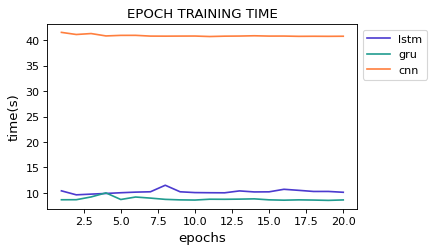

In [ ]:
EPOCHS = 20
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, lstm_history.epoch_train_time, color='#4C3BCF', label='lstm')
plt.plot(epochs, gru_history.epoch_train_time, color='#219C90', label='gru')
plt.plot(epochs, cnn_history.epoch_train_time, color='#FF7F3E', label='cnn')
plt.title("EPOCH TRAINING TIME", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)
plt.legend(fontsize=10, bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

Next we are going to visualize the training loss using a line graph for each model that was observed during model training.

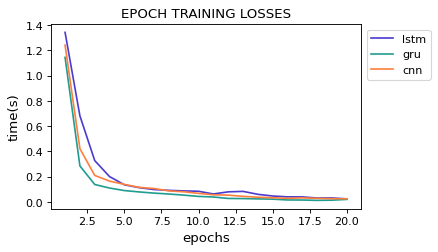

In [ ]:
EPOCHS = 20
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, lstm_history.train_losses, color='#4C3BCF', label='lstm')
plt.plot(epochs, gru_history.train_losses, color='#219C90', label='gru')
plt.plot(epochs, cnn_history.train_losses, color='#FF7F3E', label='cnn')
plt.title("EPOCH TRAINING LOSSES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)
plt.legend(fontsize=10, bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

Next we are going to visualize the validation loss using a line graph for each model that was observed during model training.

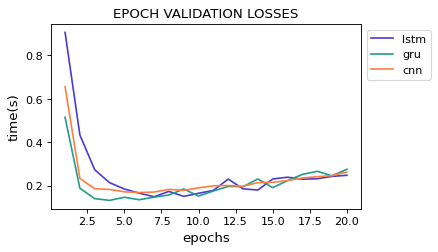

In [ ]:
EPOCHS = 20
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, lstm_history.val_losses, color='#4C3BCF', label='lstm')
plt.plot(epochs, gru_history.val_losses, color='#219C90', label='gru')
plt.plot(epochs, cnn_history.val_losses, color='#FF7F3E', label='cnn')
plt.title("EPOCH VALIDATION LOSSES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)
plt.legend(fontsize=10, bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

Next we are going to visualize the training accuracies using a line graph for each model that was observed during model training.

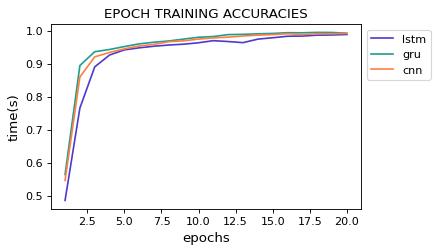

In [ ]:
EPOCHS = 20
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, lstm_history.train_acc, color='#4C3BCF', label='lstm')
plt.plot(epochs, gru_history.train_acc, color='#219C90', label='gru')
plt.plot(epochs, cnn_history.train_acc, color='#FF7F3E', label='cnn')
plt.title("EPOCH TRAINING ACCURACIES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)
plt.legend(fontsize=10, bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

Next we are going to visualize the validation accuracies using a line graph for each model that was observed during model training.

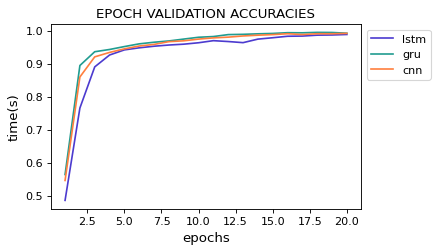

In [ ]:
EPOCHS = 20
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, lstm_history.train_acc, color='#4C3BCF', label='lstm')
plt.plot(epochs, gru_history.train_acc, color='#219C90', label='gru')
plt.plot(epochs, cnn_history.train_acc, color='#FF7F3E', label='cnn')
plt.title("EPOCH VALIDATION ACCURACIES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)
plt.legend(fontsize=10, bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

### Best model evaluations.

In the following code cell we are going to evaluate the best saved model for each model achitecture.

In [ ]:
bilstm_model.load_state_dict(torch.load('lstm.pt'))
bigru_model.load_state_dict(torch.load('gru.pt'))
cnn_model.load_state_dict(torch.load('cnn.pt'))

bilstm_test_loss, bistm_test_acc = evaluate(bilstm_model, test_loader, criterion)
bigru_test_loss, bigru_test_acc = evaluate(bigru_model, test_loader, criterion)
cnn_test_loss, cnn_test_acc = evaluate(cnn_model, test_loader, criterion)

print(f'LSTM Test Loss: {bilstm_test_loss:.3f} | LSTM Test Acc: {bistm_test_acc*100:.2f}%')
print(f'GRU Test Loss: {bigru_test_loss:.3f} | GRU Test Acc: {bigru_test_acc*100:.2f}%')
print(f'CNN Test Loss: {cnn_test_loss:.3f} | CNN Test Acc: {cnn_test_acc*100:.2f}%')

LSTM Test Loss: 0.162 | LSTM Test Acc: 92.50%
GRU Test Loss: 0.143 | GRU Test Acc: 92.40%
CNN Test Loss: 0.160 | CNN Test Acc: 92.20%


Next let's show using bar graph the test losses for each model.

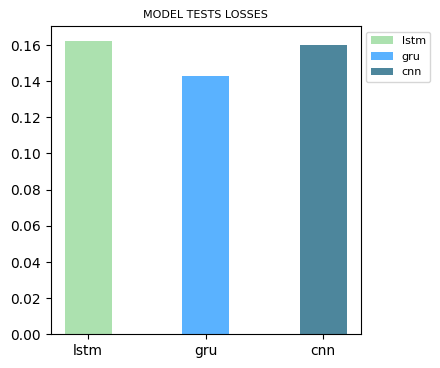

In [ ]:
plt.figure(figsize=(4, 4))
plt.bar(['lstm', 'gru', 'cnn'], [bilstm_test_loss, bigru_test_loss, cnn_test_loss], width=.4,label=['lstm', 'gru', 'cnn'],
        color=['#ACE1AF', '#5AB2FF', '#4D869C'])
plt.title("MODEL TESTS LOSSES", fontsize=8)
plt.legend(fontsize=8, labels=['lstm', 'gru', 'cnn'], bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

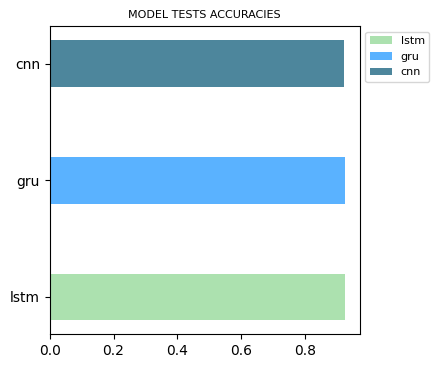

In [ ]:
plt.figure(figsize=(4, 4))
plt.barh(['lstm', 'gru', 'cnn'], [bistm_test_acc, bigru_test_acc, cnn_test_acc], height=.4,label=['lstm', 'gru', 'cnn'],
        color=['#ACE1AF', '#5AB2FF', '#4D869C'])
plt.title("MODEL TESTS ACCURACIES", fontsize=8)
plt.legend(fontsize=8, labels=['lstm', 'gru', 'cnn'], bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

Next we are going to make predictions based with our test dataset for all our 3 model achitecture.

In [ ]:
def get_predictions(model, iterator, device):
  model.eval()
  labels = []
  predictions = []
  with torch.no_grad():
    for (y, X) in iterator:
      X = X.to(device)
      lengths = torch.tensor([len(i) for i in X])
      y_pred = model(X, lengths).squeeze(1)
      y_prob = F.softmax(y_pred, dim = -1)
      labels.append(y.cpu())
      predictions.append(y_prob.cpu())
  labels = torch.cat(labels, dim = 0).numpy()
  predictions = torch.cat(predictions, dim = 0).argmax(1, keepdim = True).squeeze(1).numpy()
  return labels, predictions

# Getting the predictions and true labels for each and every model achitecture.
lstm_true, lstm_preds = get_predictions(bilstm_model, test_loader, device)
gru_true, gru_preds = get_predictions(bigru_model, test_loader, device)
cnn_true, cnn_preds = get_predictions(cnn_model, test_loader, device)

### CM OF THE `LSTM`

In the following code cell we are going to plot the `Confusion Matrix` of the `LSTM` model.

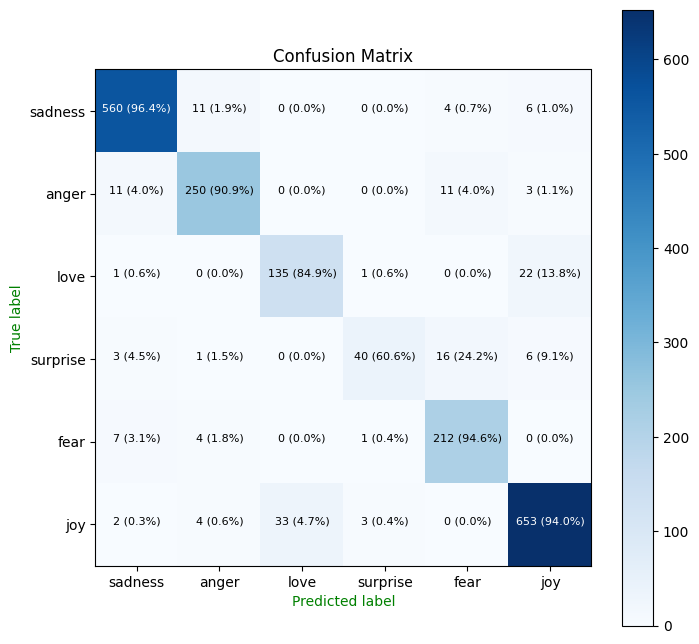

In [ ]:
plot_complicated_confusion_matrix(lstm_true, lstm_preds,
  labels_dict.keys(), fontsize=8, figsize=(8, 8)
)

### CM OF THE `GRU`

In the following code cell we are going to plot the `Confusion Matrix` of the `GRU` model.

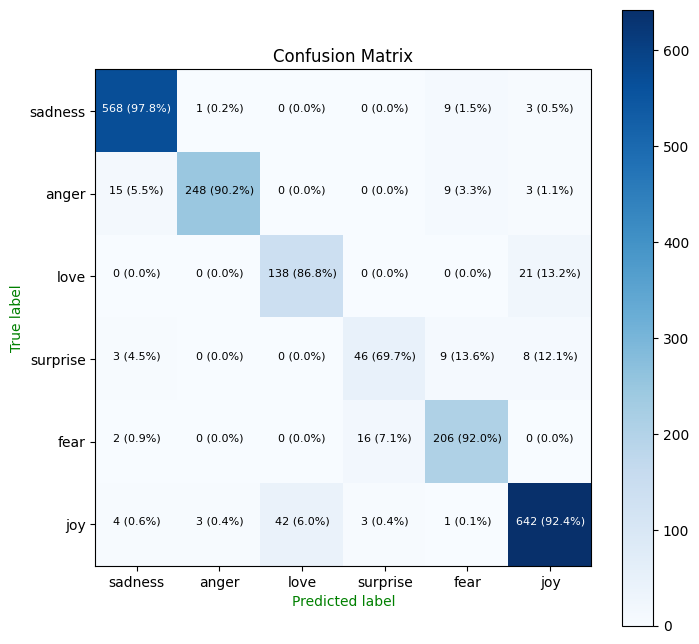

In [ ]:
plot_complicated_confusion_matrix(gru_true, gru_preds,
  labels_dict.keys(), fontsize=8, figsize=(8, 8)
)

### CM OF THE `CNN`

In the following code cell we are going to plot the `Confusion Matrix` of the `CNN` model.

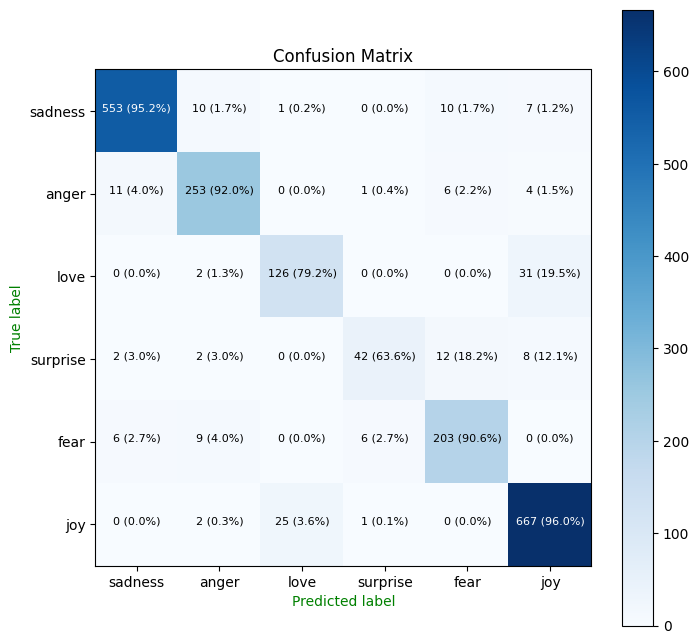

In [ ]:
plot_complicated_confusion_matrix(cnn_true, cnn_preds,
  labels_dict.keys(), fontsize=8, figsize=(8, 8)
)

### CR OF THE `LSTM`

In the following code cell we are going to print the `Classification Report` of the `LSTM` model.

In [ ]:
cr = classification_report(
    lstm_true, lstm_preds, output_dict=False,
    target_names=list(labels_dict.keys())
)
print(cr)

              precision    recall  f1-score   support

     sadness       0.96      0.96      0.96       581
       anger       0.93      0.91      0.92       275
        love       0.80      0.85      0.83       159
    surprise       0.89      0.61      0.72        66
        fear       0.87      0.95      0.91       224
         joy       0.95      0.94      0.94       695

    accuracy                           0.93      2000
   macro avg       0.90      0.87      0.88      2000
weighted avg       0.93      0.93      0.92      2000



### CR OF THE `GRU`

In the following code cell we are going to print the `Classification Report` of the `GRU` model.

In [ ]:
cr = classification_report(
    gru_true, gru_preds, output_dict=False,
    target_names=list(labels_dict.keys())
)
print(cr)

              precision    recall  f1-score   support

     sadness       0.96      0.98      0.97       581
       anger       0.98      0.90      0.94       275
        love       0.77      0.87      0.81       159
    surprise       0.71      0.70      0.70        66
        fear       0.88      0.92      0.90       224
         joy       0.95      0.92      0.94       695

    accuracy                           0.92      2000
   macro avg       0.87      0.88      0.88      2000
weighted avg       0.93      0.92      0.92      2000



### CR OF THE `CNN`

In the following code cell we are going to print the `Classification Report` of the `CNN` model.

In [ ]:
cr = classification_report(
    cnn_true, cnn_preds, output_dict=False,
    target_names=list(labels_dict.keys())
)
print(cr)

              precision    recall  f1-score   support

     sadness       0.97      0.95      0.96       581
       anger       0.91      0.92      0.92       275
        love       0.83      0.79      0.81       159
    surprise       0.84      0.64      0.72        66
        fear       0.88      0.91      0.89       224
         joy       0.93      0.96      0.94       695

    accuracy                           0.92      2000
   macro avg       0.89      0.86      0.87      2000
weighted avg       0.92      0.92      0.92      2000



### Model Inference

In this section we are going to test our models can make predictions.

In the following code cell we are going to make predictions with the best model. We will have the function called `inference_preprocess_text` which is a function that process the text for inference.

In [ ]:
def inference_preprocess_text(text, max_len=100, padding="pre"):
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  text_holder = torch.zeros(max_len, dtype=torch.int32) # fixed size tensor of max_len with  = 0
  processed_text = torch.tensor(text_pipeline(text), dtype=torch.int32)
  pos = min(max_len, len(processed_text))
  if padding == "pre":
    text_holder[:pos] = processed_text[:pos]
  else:
    text_holder[-pos:] = processed_text[-pos:]
  text_list= text_holder.unsqueeze(dim=0)
  return text_list

In [96]:
classes = list(labels_dict.keys())
def predict_emotion(model, sentence, device):
    model.eval()
    with torch.no_grad():
      tensor = inference_preprocess_text(sentence).to(device)
      length = torch.tensor([len(t) for t in tensor])
      probabilities = torch.softmax(model(tensor, length).squeeze(0), dim=0)
      prediction = torch.argmax(probabilities)
      prediction = prediction.detach().cpu()

      class_name = classes[prediction]
      prediction = prediction.item()

      table_headers =["KEY", "VALUE"]
      table_data = [
          ["PREDICTED CLASS",  prediction],
          ["PREDICTED CLASS NAME",  class_name],
          ["PROBABILITY",  round(float(probabilities[prediction].cpu()), 3)],
      ]
      tabulate_data(table_headers, table_data, title="EMOTION PREDICTIONS TABLE")

### Sadness

In [101]:
predict_emotion(cnn_model, "im updating my blog because i feel shitty.", device=device)

EMOTION PREDICTIONS TABLE
+----------------------+-------+
| KEY                  | VALUE |
+----------------------+-------+
| PREDICTED CLASS      |     5 |
| PREDICTED CLASS NAME |   joy |
| PROBABILITY          | 0.474 |
+----------------------+-------+


### Fear

In [100]:
predict_emotion(bigru_model, "i am feeling apprehensive about it but also wildly excited", device=device)

EMOTION PREDICTIONS TABLE
+----------------------+-------+
| KEY                  | VALUE |
+----------------------+-------+
| PREDICTED CLASS      |     4 |
| PREDICTED CLASS NAME |  fear |
| PROBABILITY          | 0.999 |
+----------------------+-------+


### Joy

In [102]:
predict_emotion(bilstm_model, "i feel a little mellow today.", device=device)

EMOTION PREDICTIONS TABLE
+----------------------+-------+
| KEY                  | VALUE |
+----------------------+-------+
| PREDICTED CLASS      |     5 |
| PREDICTED CLASS NAME |   joy |
| PROBABILITY          |   1.0 |
+----------------------+-------+


### Surprise

In [103]:
predict_emotion(bilstm_model, "i feel shocked and sad at the fact that there are so many sick people.", device=device)

EMOTION PREDICTIONS TABLE
+----------------------+----------+
| KEY                  |    VALUE |
+----------------------+----------+
| PREDICTED CLASS      |        3 |
| PREDICTED CLASS NAME | surprise |
| PROBABILITY          |    0.986 |
+----------------------+----------+


### Love

In [104]:
predict_emotion(bilstm_model, "i want each of you to feel my gentle embrace.", device=device)

EMOTION PREDICTIONS TABLE
+----------------------+-------+
| KEY                  | VALUE |
+----------------------+-------+
| PREDICTED CLASS      |     2 |
| PREDICTED CLASS NAME |  love |
| PROBABILITY          | 0.994 |
+----------------------+-------+


### Anger.

In [105]:
predict_emotion(bilstm_model, "i feel like my irritable sensitive combination skin has finally met it s match.", device=device)

EMOTION PREDICTIONS TABLE
+----------------------+-------+
| KEY                  | VALUE |
+----------------------+-------+
| PREDICTED CLASS      |     1 |
| PREDICTED CLASS NAME | anger |
| PROBABILITY          | 0.999 |
+----------------------+-------+
